# Initialize

Import necessary packages and data

In [42]:
from pylab import *
import netCDF4
import numpy as np
import sys
from matplotlib import colors, ticker
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
from scipy import stats
from scipy import signal
import pysal
from pandas import DataFrame
import pandas as pd

In [2]:
data = netCDF4.Dataset( '../data/cm1out.nc', 'r', format='NETCDF4')

In [3]:
# Import variables of interest
X = array(data.variables['ni'])           # radial grid values
Z = array(data.variables['nk'])           # vertical grid values
rain_fall = array(data.variables['rain']) # suface accumulated rainfall
prs = array(data.variables['prs'])        # pressure (all vertical levels)
surf_prs = array(data.variables['sps'])   # surface pressure
DH = array(data.variables['th9'])         # radial grid values
U = array(data.variables['uinterp'])      # radial velocity
V = array(data.variables['vinterp'])      # tangential velocity
W = array(data.variables['winterp'])      # vertical velocity
time = array(data.variables['time'])      # time

In [4]:
# reshape 4-dim variable to 3-dim (t,z,x)
U_T = U.reshape(U.shape[0],U.shape[1],U.shape[3])
V_T = V.reshape(V.shape[0],V.shape[1],V.shape[3])
W_T = W.reshape(W.shape[0],W.shape[1],W.shape[3])
DH_T = DH.reshape(DH.shape[0],DH.shape[1],DH.shape[3])
prs_T = prs.reshape(prs.shape[0],prs.shape[1],prs.shape[3])
# reshape 3-dim to 2-dim
s_prs_T = surf_prs.reshape(surf_prs.shape[0],surf_prs.shape[2])
s_rain = rain_fall.reshape(rain_fall.shape[0],rain_fall.shape[2])

# change pressure to mb (millibars)
prs_mb = prs_T/100
s_prs_mb = s_prs_T/100

# Early Warning Signals for V$_{max}$
Reduce data

In [5]:
t_len = 480
t_win = 440

time_test = time[40:t_len]/1440

V_test = V_T[40:t_len,:,0:99]
V_test.shape

(440, 61, 99)

Temporal variance

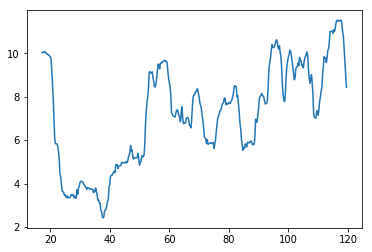

In [6]:
var_win = 30

V_max = np.amax(V_test, axis=(1,2))
V_tvar = np.empty(t_win-var_win)

for t in range(t_win-var_win):
    V_tvar[t] = np.std(V_max[t:t+var_win])
    
plt.plot(time_test[var_win-1:-1],V_tvar)

Changes in variance

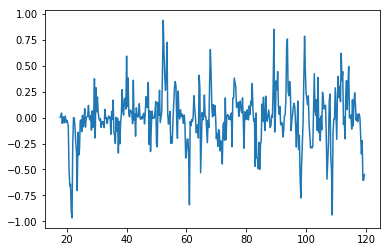

In [105]:
d_tvar = np.empty(t_win-1)
d_tvar = V_tvar[1:-1]-V_tvar[0:-2]
plt.plot(time_test[var_win+1:-1],d_tvar)

In [106]:
t_max = np.array([])
leng = d_tvar.shape[0]

tv_std = np.std(d_tvar)

for i in range(leng):
    if d_tvar[i] > 2*tv_std:
        ti = time_test[var_win+1+i]
        t_max = np.append(t_max,ti)
        
print(t_max)

[ 40.    52.25  52.5   53.5   68.    89.25  93.5   93.75  99.5  111.75]


Spatial Variance of V_T

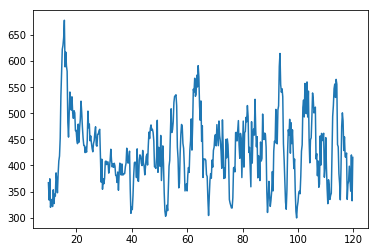

In [9]:
V_svar = np.var(V_test,axis=(1,2))
plt.plot(time_test,V_svar)

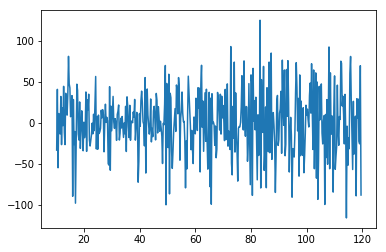

In [107]:
d_svar = np.empty(t_win-1)
d_svar = V_svar[1:-1]-V_svar[0:-2]
plt.plot(time_test[1:-1],d_svar)

In [108]:
s_max = np.array([])
leng = d_svar.shape[0]

sv_std = np.std(d_svar)

for i in range(leng):
    if d_svar[i] > 2*sv_std:
        si = time_test[1+i]
        s_max = np.append(s_max,si)
        
print(s_max)

[ 14.5   72.75  83.25  87.25 108.   115.75]


Autocorrelation of V$_{max}$ (lag = 6 hours)

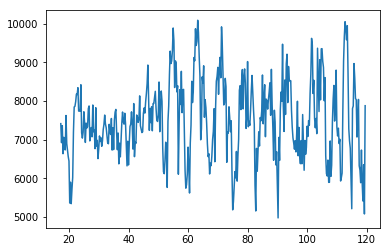

In [12]:
ac_win = 30
lag = 1

V_acorr = np.empty(t_win-ac_win)

for t in range(t_win-ac_win):
    corr_t = signal.correlate(V_max[t:t+ac_win],V_max[t+lag:t+ac_win+lag])
    V_acorr[t] = corr_t[0]
    
plt.plot(time_test[ac_win-1:-lag],V_acorr)

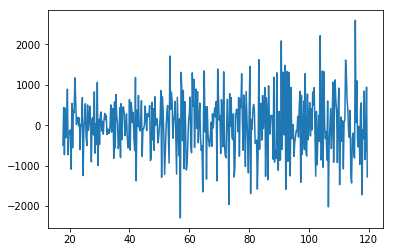

In [109]:
d_acor = np.empty(ac_win-1)
d_acor = V_acorr[1:-1]-V_acorr[0:-2]
plt.plot(time_test[var_win+1:-1],d_acor)

In [110]:
ac_max = np.array([])
leng = d_acor.shape[0]

ac_std = np.std(d_acor)

for i in range(leng):
    if d_acor[i] > 2*ac_std:
        aci = time_test[1+i]
        ac_max = np.append(ac_max,aci)
        
print(ac_max)

[ 46.    72.75  75.75  83.25  84.5   96.25 104.75 108.  ]


Spatial correlation

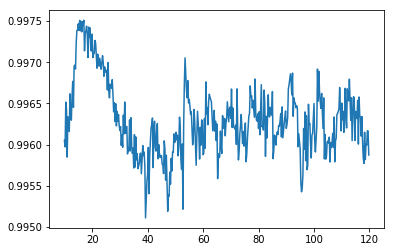

In [15]:
V_corr = np.empty(t_win)
w = pysal.lat2W(61,99)

for t in range(t_win):
    corr_t = pysal.Moran(V_test[t,:,:],w)
    V_corr[t] = corr_t.I
    
plt.plot(time_test,V_corr)

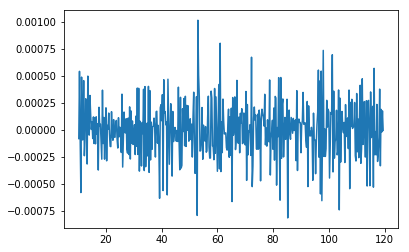

In [111]:
d_scor = np.empty(t_win-1)
d_scor = V_corr[1:-1]-V_corr[0:-2]
plt.plot(time_test[1:-1],d_scor)

In [112]:
sc_max = np.array([])
leng = d_scor.shape[0]

sc_std = np.std(d_scor)

for i in range(leng):
    if d_scor[i] > 2*sc_std:
        sci = time_test[1+i]
        sc_max = np.append(sc_max,sci)
        
print(sc_max)

[ 10.5   53.    61.    72.25  96.25  97.25  98.   101.25 116.25]


Temporal Skewness

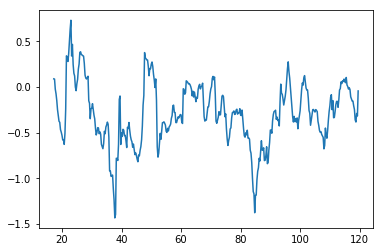

In [18]:
skw_win = 30

V_skw = np.empty(t_win-skw_win)

for t in range(t_win-skw_win):
    V_skw[t] = stats.skew(V_max[t:t+skw_win])
    
plt.plot(time_test[skw_win-1:-1],V_skw)

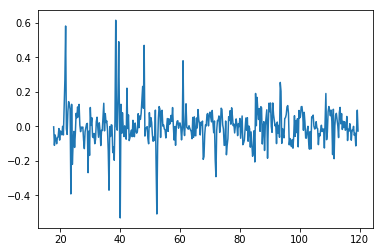

In [113]:
d_skw = np.empty(t_win-1)
d_skw  = V_skw[1:-1]-V_skw[0:-2]
plt.plot(time_test[skw_win+1:-1],d_skw)

In [114]:
skw_max = np.array([])
leng = d_skw.shape[0]

skw_std = np.std(d_skw)

for i in range(leng):
    if d_skw[i] < -2*skw_std:
        ski = time_test[1+i]
        skw_max = np.append(skw_max,ski)
        
print(skw_max)

[16.   16.5  21.75 28.75 32.5  44.5  44.75 64.5 ]


# Early Warning Signals for U$_{min}$
Reduce data

In [86]:
U_test = U_T[40:t_len,:,0:99]
U_test.shape

(440, 61, 99)

Temporal variance

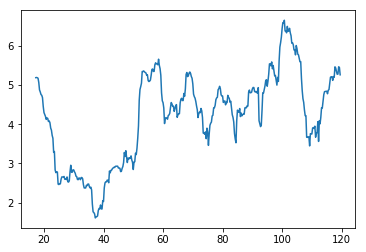

In [87]:
var_win = 30

U_max = np.amax(U_test, axis=(1,2))
U_tvar = np.empty(t_win-var_win)

for t in range(t_win-var_win):
    U_tvar[t] = np.std(U_max[t:t+var_win])
    
plt.plot(time_test[var_win-1:-1],U_tvar)

Changes in variance

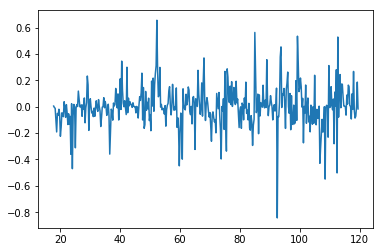

In [115]:
d_tvar_u = np.empty(t_win-1)
d_tvar_u = U_tvar[1:-1]-U_tvar[0:-2]
plt.plot(time_test[var_win+1:-1],d_tvar_u)

In [116]:
t_max_u = np.array([])
leng = d_tvar_u.shape[0]

tv_std = np.std(d_tvar_u)

for i in range(leng):
    if d_tvar_u[i] > 2*tv_std:
        ti = time_test[var_win+1+i]
        t_max_u = np.append(t_max_u,ti)
        
print(t_max_u)

[ 40.5   52.    52.25  68.    85.    89.    93.5   93.75  99.25  99.5
 109.75 112.75]


Spatial Variance

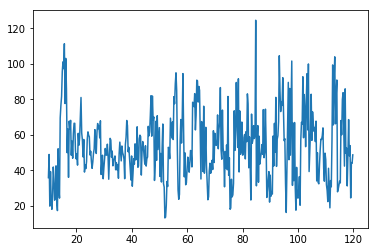

In [91]:
U_svar = np.var(U_test,axis=(1,2))
plt.plot(time_test,U_svar)

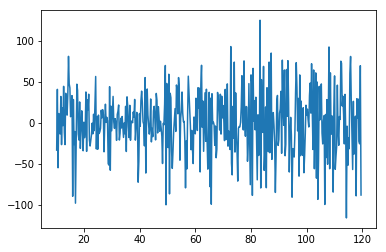

In [117]:
d_svar_u = np.empty(t_win-1)
d_svar_u = V_svar[1:-1]-V_svar[0:-2]
plt.plot(time_test[1:-1],d_svar_u)

In [118]:
s_max_u = np.array([])
leng = d_svar_u.shape[0]

sv_std = np.std(d_svar_u)

for i in range(leng):
    if d_svar_u[i] > 2*sv_std:
        si = time_test[1+i]
        s_max_u = np.append(s_max_u,si)
        
print(s_max_u)

[ 14.5   72.75  83.25  87.25 108.   115.75]


Autocorrelation of V$_{max}$ (lag = 6 hours)

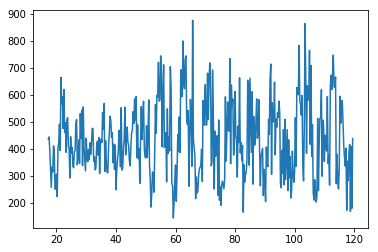

In [94]:
ac_win = 30
lag = 1

U_acorr = np.empty(t_win-ac_win)

for t in range(t_win-ac_win):
    corr_t = signal.correlate(U_max[t:t+ac_win],U_max[t+lag:t+ac_win+lag])
    U_acorr[t] = corr_t[0]
    
plt.plot(time_test[ac_win-1:-lag],U_acorr)

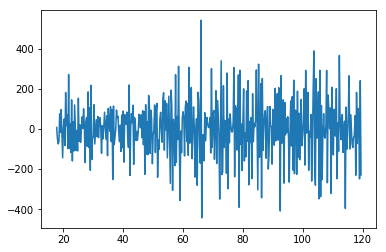

In [119]:
d_acor_u = np.empty(ac_win-1)
d_acor_u = U_acorr[1:-1]-U_acorr[0:-2]
plt.plot(time_test[var_win+1:-1],d_acor_u)

In [120]:
ac_max_u = np.array([])
leng = d_acor_u.shape[0]

ac_std = np.std(d_acor_u)

for i in range(leng):
    if d_acor_u[i] > 2*ac_std:
        aci = time_test[1+i]
        ac_max_u = np.append(ac_max_u,aci)
        
print(ac_max_u)

[ 51.    54.5   58.5   62.    65.25  69.5   77.75  96.25 104.75]


Spatial correlation

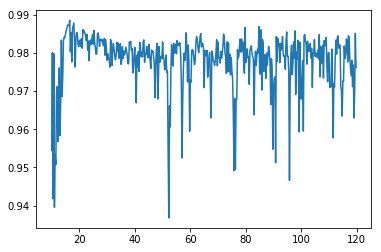

In [99]:
U_corr = np.empty(t_win)
w = pysal.lat2W(61,99)

for t in range(t_win):
    corr_t = pysal.Moran(U_test[t,:,:],w)
    U_corr[t] = corr_t.I
    
plt.plot(time_test,U_corr)

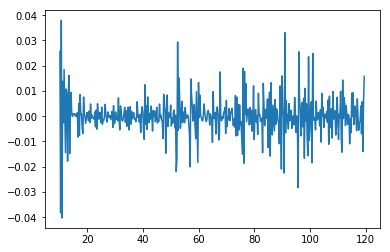

In [121]:
d_scor_u = np.empty(t_win-1)
d_scor_u = U_corr[1:-1]-U_corr[0:-2]
plt.plot(time_test[1:-1],d_scor_u)

In [122]:
sc_max_u = np.array([])
leng = d_scor_u.shape[0]

sc_std = np.std(d_scor_u)

for i in range(leng):
    if d_scor_u[i] > 2*sc_std:
        sci = time_test[1+i]
        sc_max_u = np.append(sc_max_u,sci)
        
print(sc_max_u)

[ 10.25  10.75  11.75  13.5   52.5   67.75  76.    76.5   90.    91.
  96.    99.5  101.   119.5 ]


Temporal Skewness

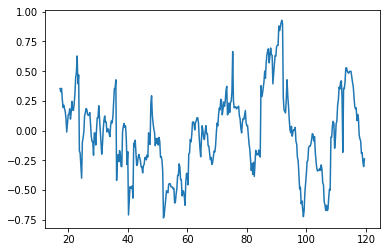

In [102]:
skw_win = 30

U_skw = np.empty(t_win-skw_win)

for t in range(t_win-skw_win):
    U_skw[t] = stats.skew(U_max[t:t+skw_win])
    
plt.plot(time_test[skw_win-1:-1],U_skw)

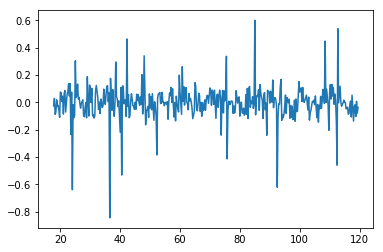

In [123]:
d_skw_u = np.empty(t_win-1)
d_skw_u  = U_skw[1:-1]-U_skw[0:-2]
plt.plot(time_test[skw_win+1:-1],d_skw_u)

In [124]:
skw_max_u = np.array([])
leng = d_skw_u.shape[0]

skw_std = np.std(d_skw_u)

for i in range(leng):
    if d_skw_u[i] < -2*skw_std:
        ski = time_test[1+i]
        skw_max_u = np.append(skw_max_u,ski)
        
print(skw_max_u)

[ 16.5   29.    33.    44.75  68.25  85.   105.  ]


# Comparing EWS
Eyewall replacement cycles identified previously (Quinn 2015)

In [81]:
ERCs = np.array([52, 53, 54, 76, 77, 90, 91, 95, 96, 99, 100, 101, 107, 108, 110, 111, 112])

Function to make lists all same size for table viewing

In [82]:
def append_nones(length, list_):
    """
    Appends Nones to list to get length of list equal to `length`.
    If list is too long raise AttributeError
    """
    diff_len = length - len(list_)
    if diff_len < 0:
        raise AttributeError('Length error list is too long.')
    a = np.empty(diff_len)
    a[:] = np.nan
    return np.append(list_,a)

Make EWS lists same length

In [125]:
long_list = np.amax([ERCs.shape[0],t_max.shape[0],s_max.shape[0],ac_max.shape[0],
                   sc_max.shape[0],skw_max.shape[0]])

ERCs = append_nones(long_list,ERCs)
t_max = append_nones(long_list,t_max)
s_max = append_nones(long_list,s_max)
ac_max = append_nones(long_list,ac_max)
sc_max = append_nones(long_list,sc_max)
skw_max = append_nones(long_list,skw_max)

long_list_u = np.amax([ERCs.shape[0],t_max_u.shape[0],s_max_u.shape[0],ac_max_u.shape[0],
                   sc_max_u.shape[0],skw_max_u.shape[0]])

t_max_u = append_nones(long_list_u,t_max_u)
s_max_u = append_nones(long_list_u,s_max_u)
ac_max_u = append_nones(long_list_u,ac_max_u)
sc_max_u = append_nones(long_list_u,sc_max_u)
skw_max_u = append_nones(long_list_u,skw_max_u)

Table of EWS for V_T

In [126]:
d_erc = {'ERCs': ERCs, 'Variance (temporal)': t_max, 'Variance (spatial)': s_max, 
     'Autocorrelation': ac_max,'Spatial correlation': sc_max,'Skewness': skw_max}
df_erc = pd.DataFrame(d_erc)
df_erc

,ERCs,Variance (temporal),Variance (spatial),Autocorrelation,Spatial correlation,Skewness
0,52.0,40.00,14.50,46.00,10.50,16.00
1,53.0,52.25,72.75,72.75,53.00,16.50
2,54.0,52.50,83.25,75.75,61.00,21.75
3,76.0,53.50,87.25,83.25,72.25,28.75
4,77.0,68.00,108.00,84.50,96.25,32.50
5,90.0,89.25,115.75,96.25,97.25,44.50
6,91.0,93.50,NaN,104.75,98.00,44.75
7,95.0,93.75,NaN,108.00,101.25,64.50
8,96.0,99.50,NaN,NaN,116.25,NaN
9,99.0,111.75,NaN,NaN,NaN,NaN


Table of EWS for U_T

In [127]:
d_erc_u = {'ERCs': ERCs, 'Variance (temporal)': t_max_u, 'Variance (spatial)': s_max_u, 
     'Autocorrelation': ac_max_u,'Spatial correlation': sc_max_u,'Skewness': skw_max_u}
df_erc_u = pd.DataFrame(d_erc_u)
df_erc_u

,ERCs,Variance (temporal),Variance (spatial),Autocorrelation,Spatial correlation,Skewness
0,52.0,40.50,14.50,51.00,10.25,16.50
1,53.0,52.00,72.75,54.50,10.75,29.00
2,54.0,52.25,83.25,58.50,11.75,33.00
3,76.0,68.00,87.25,62.00,13.50,44.75
4,77.0,85.00,108.00,65.25,52.50,68.25
5,90.0,89.00,115.75,69.50,67.75,85.00
6,91.0,93.50,NaN,77.75,76.00,105.00
7,95.0,93.75,NaN,96.25,76.50,NaN
8,96.0,99.25,NaN,104.75,90.00,NaN
9,99.0,99.50,NaN,NaN,91.00,NaN
